# 🍔👁 Food Vision Big™


import packages

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.


|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle | 
| Train data | 75,750 images | 7,575 images | 
| Test data | 25,250 images | 25,250 images | 
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) | 


> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

Steps:
* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
* Batching & preparing datasets for modelling (**making our datasets run fast**)
* Creating modelling callbacks
* Setting up **mixed precision training**
* Building a feature extraction model (see [transfer learning part 1: feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb))
* Fine-tuning the feature extraction model (see [transfer learning part 2: fine-tuning](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb))
* Viewing training results on TensorBoard

In [1]:
import sys, os

sys.path.append("..")  # append to system paths

import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
from food_vision.utils.evaluation_utils import (
    build_confusion_matrix,
    plot_learning_curves,
    performance_metrics,
)
import numpy as np
from food_vision.utils.callback_utils import (
    model_checkpoint_callback,
    tensorboard_callback,
    learning_rate_scheduler_callback,
    early_stop_callback,
)
from food_vision.utils.preprocessing_utils import preprocess_image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


%load_ext lab_black

## Get Data

In [2]:
datasets_list = tfds.list_builders()  # get all available datasets in TFDS
print("food101" in datasets_list)  # is the dataset we're after available?

True


In [42]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(
    name="food101",  # target dataset to get from TFDS
    split=[
        "train",
        "validation",
    ],  # what splits of data should we get? note: not all datasets have train, valid, test
    as_supervised=True,  # download data in tuple format (sample, label), e.g. (image, label)
    with_info=True,
)  # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    data_path='/Users/chen_bowen/tensorflow_datasets/food101/2.0.0',
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=7

find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

In [5]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [7]:
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [8]:
# Output info about our training sample
for image, label in train_one_sample:
    print(
        f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """
    )


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
        


2021-12-31 00:45:42.115552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


image number range

In [9]:
image.numpy().min(), image.numpy().max()

(0, 255)

plot one image

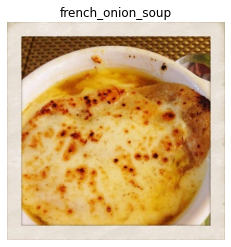

In [10]:
plt.imshow(image)
plt.title(
    class_names[label.numpy()]
)  # add title to image by indexing on class_names list
plt.axis(False)
plt.show()

## Data Preprocessing

using map and prefetch

In [43]:
# apply preprocessing and shuffle for both train and test datasets
train_data = train_data.map(
    map_func=lambda img, label: preprocess_image(
        img, label, img_shape=224, scale=False
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)
train_data = (
    train_data.shuffle(buffer_size=100)
    .batch(batch_size=32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_data = test_data.map(
    map_func=lambda img, label: preprocess_image(
        img, label, img_shape=224, scale=False
    ),
    num_parallel_calls=tf.data.AUTOTUNE,
)
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create Model Callbacks

In [13]:
def model_checkpoint_callback(checkpoint_dir, save_weights_only=False):
    """
    Create a model save checkpoint given the saved directory

    Args:
      checkpoint_dir (str): target directory to store model checkpoint files
    """
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_dir,
        montior="val_accuracy",  # save the model weights with best validation accuracy
        save_best_only=True,  # only save the best weights
        save_weights_only=save_weights_only,  # only save model weights (not whole model)
        verbose=1,
    )
    return model_checkpoint

In [14]:
def tensorboard_callback(dir_name, experiment_name):
    """
    Creates a TensorBoard callback instand to store log files.

    Stores log files with the filepath:
      "dir_name/experiment_name/current_datetime/"

    Args:
      dir_name: target directory to store TensorBoard log files
      experiment_name: name of experiment directory (e.g. efficientnet_model_1)
    """
    log_dir = (
        dir_name
        + "/"
        + experiment_name
        + "/"
        + datetime.now().strftime("%Y%m%d-%H%M%S")
    )
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Mixed Precision 

Currently doesn't work on M1 Metal

In [15]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(
    policy="float32"  # set global policy to mixed precision result in warning
)

## Build the Model

build transfer learning model with EfficientNetB0 as backbone

In [16]:
def modified_EfficientNet_model(
    input_shape=(224, 224, 3), output_shape=len(class_names)
):
    # create base model
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False  # freeze base model layers

    # create functional inputs
    inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float32)
    a = base_model(inputs, training=False)
    b = layers.GlobalAveragePooling2D(name="average_pool")(a)
    c = layers.Dense(output_shape)(b)
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(c)

    model = tf.keras.Model(inputs, outputs)

    # compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    return model

In [17]:
model = modified_EfficientNet_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 average_pool (GlobalAverage  (None, 1408)             0         
 Pooling2D)                                                      
                                                                 
 dense (Dense)               (None, 101)               142309    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 7,910,878
Trainable params: 142,309
Non-trainab

In [18]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)  #

input_layer True float32 <Policy "float32">
efficientnetb2 False float32 <Policy "float32">
average_pool True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


## Fit the Model

In [19]:
training_history = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        tensorboard_callback(
            "training_logs", "efficientnetb2_101_classes_all_data_feature_extracts"
        ),
        model_checkpoint_callback(
            "model_checkpoints/trained_model_b2", save_weights_only=False
        ),
    ],
)

Saving TensorBoard log files to: training_logs/efficientnetb2_101_classes_all_data_feature_extracts/20211231-004543
Epoch 1/3


/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2021-12-31 00:45:45.544053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 1.7997 - accuracy: 0.5580

2021-12-31 00:58:26.144239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.22093, saving model to model_checkpoints/trained_model_b2


2021-12-31 00:59:10.090285: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets


INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 822s 346ms/step - loss: 1.7997 - accuracy: 0.5580 - val_loss: 1.2209 - val_accuracy: 0.6862
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2862 - accuracy: 0.6669
Epoch 00002: val_loss improved from 1.22093 to 1.12750, saving model to model_checkpoints/trained_model_b2
INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets


INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 812s 343ms/step - loss: 1.2862 - accuracy: 0.6669 - val_loss: 1.1275 - val_accuracy: 0.7029
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1346 - accuracy: 0.7026
Epoch 00003: val_loss improved from 1.12750 to 1.09181, saving model to model_checkpoints/trained_model_b2
INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets


INFO:tensorflow:Assets written to: model_checkpoints/trained_model_b2/assets
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 812s 343ms/step - loss: 1.1346 - accuracy: 0.7026 - val_loss: 1.0918 - val_accuracy: 0.7100


evaluate the model

In [20]:
performance_metrics = model.evaluate(test_data)
performance_metrics

790/790 [==============================] - 251s 318ms/step - loss: 1.1044 - accuracy: 0.7004


[1.1043932437896729, 0.7003960609436035]

## Fine Tune the Model

Reload checkpoint to make sure evaluations results are identical

In [21]:
cloned_model = tf.keras.models.load_model("model_checkpoints/trained_model_b2")
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb2 (Functional)  (None, None, None, 1408)  7768569  
                                                                 
 average_pool (GlobalAverage  (None, 1408)             0         
 Pooling2D)                                                      
                                                                 
 dense (Dense)               (None, 101)               142309    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 7,910,878
Trainable params: 142,309
Non-trainab

In [22]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)
results_cloned_model_with_loaded_weights

2021-12-31 01:30:49.884780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 254s 320ms/step - loss: 1.1044 - accuracy: 0.7004


[1.1043938398361206, 0.7003960609436035]

In [23]:
assert np.isclose(performance_metrics, results_cloned_model_with_loaded_weights).all()

## Fine Tune the Model

Set all layers to be trainable due to the fact that we have plenty of data

In [24]:
# cloned_model.trainable = True
for layer in cloned_model.layers:
    layer.trainable = True  # set all layers to trainable
    print(
        layer.name, layer.trainable, layer.dtype, layer.dtype_policy
    )  # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb2 True float32 <Policy "float32">
average_pool True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


Recompile

In [25]:
cloned_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(
        0.0001
    ),  # 10x lower learning rate than the default
    metrics=["accuracy"],
)

Train

In [26]:
fine_tuned_history = cloned_model.fit(
    train_data,
    epochs=5,  # fine-tune for a maximum of 100 epochs
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(
        0.15 * len(test_data)
    ),  # validation during training on 15% of test data
    callbacks=[
        tensorboard_callback(
            "training_logs", "efficientb2_101_classes_all_data_fine_tuning"
        ),  # track the model training logs
        model_checkpoint_callback(
            "tuned_model_checkpoints/trained_model_b2", save_weights_only=False
        ),  # save only the best model during training
        early_stop_callback(
            monitor="val_accuracy", patience=5
        ),  # stop model after X epochs of no improvements
        learning_rate_scheduler_callback(
            monitor="val_accuracy",
            factor=0.2,  # multiply the learning rate by 0.2 (reduce by 5x)
            patience=1,
            verbose=1,  # print out when learning rate goes down
            min_lr=1e-7,
        ),
    ],
)  # reduce the learning rate after X epochs of n

Saving TensorBoard log files to: training_logs/efficientb2_101_classes_all_data_fine_tuning/20211231-013503
Epoch 1/5


2021-12-31 01:35:05.836084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.7521

2021-12-31 06:52:40.394800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.77138, saving model to tuned_model_checkpoints/trained_model_b2
INFO:tensorflow:Assets written to: tuned_model_checkpoints/trained_model_b2/assets


INFO:tensorflow:Assets written to: tuned_model_checkpoints/trained_model_b2/assets
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 19121s 8s/step - loss: 0.9207 - accuracy: 0.7521 - val_loss: 0.7714 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.8661
Epoch 00002: val_loss improved from 0.77138 to 0.75156, saving model to tuned_model_checkpoints/trained_model_b2
INFO:tensorflow:Assets written to: tuned_model_checkpoints/trained_model_b2/assets


INFO:tensorflow:Assets written to: tuned_model_checkpoints/trained_model_b2/assets
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/Users/chen_bowen/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 23142s 10s/step - loss: 0.4794 - accuracy: 0.8661 - val_loss: 0.7516 - val_accuracy: 0.7953 - lr: 1.0000e-04


Small evaluation

In [27]:
performance_metrics = cloned_model.evaluate(test_data)
performance_metrics

790/790 [==============================] - 260s 326ms/step - loss: 0.7648 - accuracy: 0.7919


[0.7647774815559387, 0.7919208407402039]

upload to tensorboard

In [28]:
# !tensorboard dev upload --logdir ./training_logs    --name "Fine-tuning EfficientNetB0 on all Food101 Data"
# --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \

## Visualizing predictions on test images

1. get all model predictions

In [49]:
predictions = cloned_model.predict(test_data, verbose=1)

790/790 [==============================] - 267s 337ms/step


2. get the predicted class from the predictions by obtaining its highest probability

In [50]:
predicted_class = predictions.argmax(axis=1)
highest_predicted_prob = predictions.max(axis=1)

3. Build dataframe for image_id, predicted score, predicted class and actual class

In [53]:
import pandas as pd

y = np.concatenate([y for x, y in test_data], axis=0)
eval_df = pd.DataFrame(
    {
        "image_id": np.arange(len(predicted_class)),
        "actual_class": y,
        "predicted_class": predicted_class,
        "highest_predicted_prob": highest_predicted_prob,
        "actual_class_names": [class_names[i] for i in y],
        "predicted_class_names": [class_names[i] for i in predicted_class],
    }
)

In [55]:
image_id_map = {i: image for i, (image, label) in enumerate(test_data.unbatch())}

4. Plot the most wrong predictions

In [56]:
most_wrong_predictions = eval_df[
    eval_df["predicted_class"] != eval_df["actual_class"]
].sort_values(by="highest_predicted_prob", ascending=False)

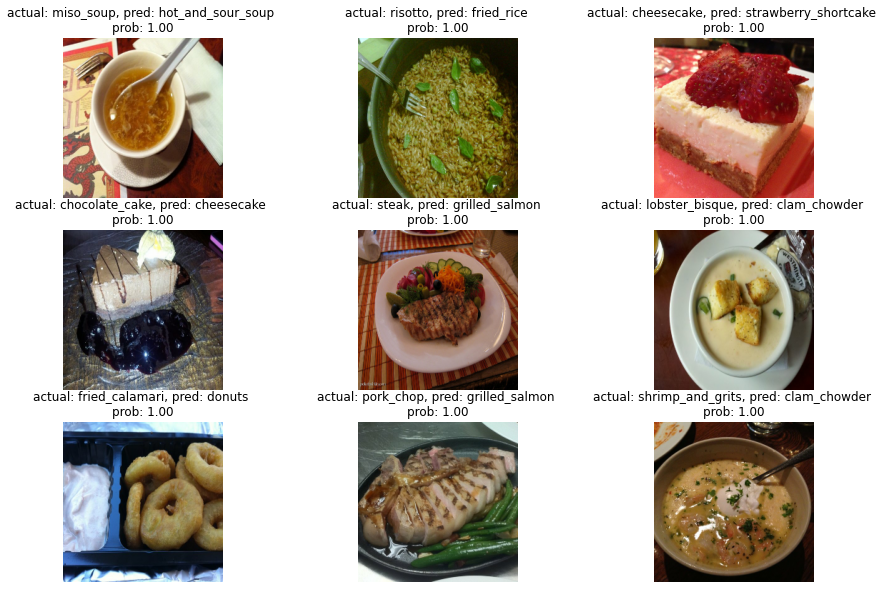

In [59]:
images_to_view = 9
start_index = 10  # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(
    most_wrong_predictions[start_index : start_index + images_to_view].itertuples()
):
    plt.subplot(3, 3, i + 1)
    (
        image_id,
        _,
        _,
        _,
        highest_predicted_prob,
        actual_class_names,
        predicted_class_names,
    ) = row  # only interested in a few parameters of each row
    img = tf.cast(image_id_map[image_id], tf.int64)
    plt.imshow(img)
    plt.title(
        f"actual: {actual_class_names}, pred: {predicted_class_names} \nprob: {highest_predicted_prob:.2f}"
    )
    plt.axis(False)